In [1]:
# install required packages
!pip install yfinance --upgrade --no-cache-dir

# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=0eba19b7f4d4813f56c96310bfaa3a7fb29ed1bfccc6d32b3be97b95efbe71d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-4ofvvylv/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [2]:
# find today's date
today = dt.date.today()
# delta = 1 day time delta
delta = dt.timedelta(days = 1)
# end_delta = 10 years ago
end_delta = dt.timedelta(days = 3652)

# Set the end of the sample to yesterday
end_of_sample = (today - delta)
# Set the start of the sample to 10 years ago
start_of_sample = (end_of_sample - end_delta)

# Change the data format from a 'datetime' element to a string which can be interpreted by Yahoo! Finance
end_of_sample = end_of_sample.isoformat()
start_of_sample = start_of_sample.isoformat()

In [3]:
# use Datreader to import S&P500 Data within the defined sample period
from pandas_datareader import data as pdr
dataset = pdr.get_data_yahoo("^GSPC", start=start_of_sample, end=end_of_sample).reset_index()

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [4]:
# define the conditions under which the algorithm should trigger a buy order or sell order
count = int(np.ceil(len(dataset) * 0.1))

action = pd.DataFrame(index=dataset.index)
action['trigger'] = 0.0
action['trend'] = dataset['Adj Close']

action['RollingMax'] = (action.trend.shift(1).rolling(count).max())
action['RollingMin'] = (action.trend.shift(1).rolling(count).min())

action.loc[action['RollingMax'] < action.trend, 'trigger'] = -1
action.loc[action['RollingMin'] > action.trend, 'trigger'] = 1

In [5]:
# this executable is a decision function for the algorithm
def trade(price_change, trigger, capital = 10_000, maximum_long = 1, maximum_short = 1,):
    """
    price_change = S&P500 price change (Absolute Value)
    trigger = 1 initiates a buy order, -1 initiates sell order
    capital = The initial capital committed to algorithm (the _ acts as a comma for large values)
    maximum_long = the maximum quantity that can be purchased in any one action
    maximum_short = maximum quantity that can be sold in any one action (note the shortselling restriction)
    """
    starting_capital = capital
    sell_states = []
    buy_states = []
    inventory = 0

    def buy(i, capital, inventory):
        shares = capital // price_change[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough capital to buy a unit price %f'
                % (i, capital, price_change[i])
            )
        else:
            if shares > maximum_long:
                buy_units = maximum_long
            else:
                buy_units = shares
            capital -= buy_units * price_change[i]
            inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * price_change[i], capital)
            )
            buy_states.append(0)
        return capital, inventory

    for i in range(price_change.shape[0] - int(0.025 * len(dataset))):
        state = trigger[i]
        if state == 1:
            capital, inventory = buy( i, capital, inventory)
            buy_states.append(i)
        elif state == -1:
            if inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if inventory > maximum_short:
                    sell_units = maximum_short
                else:
                    sell_units = inventory
                inventory -= sell_units
                total_sell = sell_units * price_change[i]
                capital += total_sell
                try:
                    invest = (
                        (price_change[i] - price_change[buy_states[-1]])
                        / price_change[buy_states[-1]]) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, capital))
            sell_states.append(i)
            
    invest = ((capital - starting_capital) / starting_capital) * 100
    total_gains = capital - starting_capital
    return buy_states, sell_states, total_gains, invest

In [ ]:
# we must pass arguments to the decision function
buy_states, sell_states, total_gains, invest = trade(dataset['Adj Close'], action['trigger'])

In [7]:
# Let's define a quick function which generates the Index returns, to allow benchmarking
def Index_Returns(start_value, end_value):
    return (((end_value - start_value) / start_value) -1) * 100

# We can pass this function the required arguments to calculate a simple return
SP_500_Returns = Index_Returns(dataset['Adj Close'].iloc[0], dataset['Adj Close'].iloc[-1])

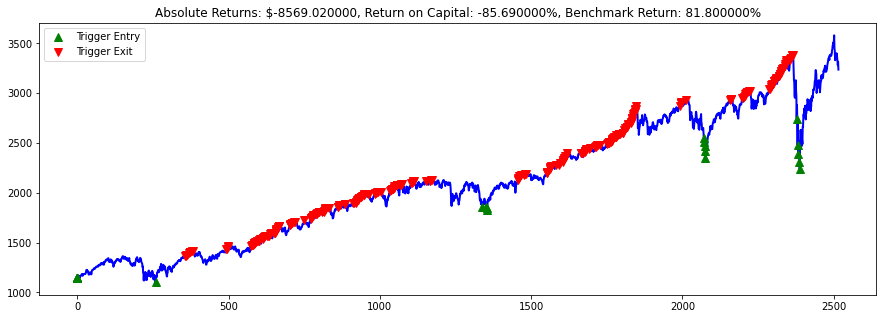

In [8]:
# Plot the S&P500 Closing Price
value = dataset['Adj Close']
fig = plt.figure(figsize = (15,5))
plt.plot(value, color='b', lw=2.)

# Plot the Entry and Exit Signals generated by the algorithm
plt.plot(value, '^', markersize=8, color='g', label = 'Trigger Entry', markevery = buy_states)
plt.plot(value, 'v', markersize=8, color='r', label = 'Trigger Exit', markevery = sell_states)

# Chart Title displaying the Absolute Returns, Return on Capital & Benchmark Returns
plt.title('Absolute Returns: $%f, Return on Capital: %f%%, Benchmark Return: %f%%'%(round(total_gains,2), round(invest,2), round(SP_500_Returns,2)))
plt.legend()
plt.show();